# Custom Implementation of VGG16, ResNet18, & MobileNetV2 

In [25]:
# Importing packages
import torch
import os 

# Defining training and testing paths
training_path=r"C:\Users\97158\Desktop\Apziva\Project 4-MonReader\images\training"
testing_path=r"C:\Users\97158\Desktop\Apziva\Project 4-MonReader\images\testing"  

In [26]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [27]:
print("Is CUDA Available?: ", torch.cuda.is_available())
print("Device No.: ", torch.cuda.current_device())
print("Device Name: ", torch.cuda.get_device_name())

Is CUDA Available?:  True
Device No.:  0
Device Name:  NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [28]:
# Specifying mean and SD from imagenet dataset statistics
Mean= [0.485, 0.456, 0.406]
STD= [0.229, 0.224, 0.225]

# Specifying training hyperparameters
#Image_size=256
Image_size=768
Batch_size= 18
#Pred_batch_size= 4
EPOCHS=16
LR=0.0008

# Determining the device type
Device= torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [29]:
# Creating the directory if it doesn't exist
os.makedirs("model_output", exist_ok=True)

# Defining paths to store trained model
VGG_Model_path= os.path.join("model_output","VGG_model.pth")
RESNET_Model_path= os.path.join("model_output","ResNet_model.pth")
MobileNet_Model_path=os.path.join("model_output","MobileNet_model.pth")

Training our Classifier


In [30]:
# Importing all the packages

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import RandomResizedCrop
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import RandomRotation
from torchvision.transforms import Normalize
from torchvision.transforms import Resize
from torchvision.transforms import transforms
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.nn import Softmax
from torch.nn import LogSoftmax
from torch.nn import ReLU
from torch.nn import Dropout
from torch import optim
from tqdm import tqdm
from matplotlib import pyplot as plt 
import argparse

import pandas as pd

In [31]:
# Importing the necessary packages
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# Defining the dataloader function
def get_Dataloader(Dataset, Batch_size, shuffle=True):
    dl=DataLoader(Dataset,Batch_size,shuffle=shuffle)
    return dl
# Train_Val Dataset Splitter

def train_val_split(Dataset, val_split=0.2):

    total_size=len(Dataset)
    (train_idx, val_idx)= train_test_split(list(range(total_size)),test_size=val_split)

    train_set=Subset(Dataset,train_idx)
    test_set=Subset(Dataset,val_idx)

    return train_set,test_set

In [32]:
# Defining the tranform pipeline

# Create training dataset using Imagefolder
trainTransform=Compose([
    Resize((Image_size, Image_size)),
    #RandomResizedCrop(Image_size),
    #RandomHorizontalFlip(),
    #RandomRotation(90),
    ToTensor(),
    Normalize(Mean, STD)
])

# Creating training dataset using Imagefolder
train_dataset=ImageFolder(training_path,trainTransform)

In [33]:
# Creating training and validation split
(TrainDataset, ValDataset)= train_val_split(Dataset=train_dataset)

# Creating training and validation data loaders
train_laoder=get_Dataloader(Dataset=TrainDataset, Batch_size=Batch_size)
val_loader=get_Dataloader(Dataset=ValDataset, Batch_size=Batch_size)

In [34]:
# Calculating Steps per epoch for training and validation set
train_step= len(TrainDataset)/Batch_size
val_step= len(ValDataset)/Batch_size

print("Train_Step: {:.2f}\nVal_step: {:.2f}".format(train_step, val_step))

#Initializing the results directory to store history for plotting
Train_Val_Hist={
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]}

Train_Step: 106.28
Val_step: 26.61


In [35]:
# Constructing an argument parser to choose between models from the command line

import sys
sys.argv=['']
del sys

ap=argparse.ArgumentParser()
ap.add_argument('-m','--model',type=str,default='resnet', choices=['vgg','resnet','mobilenet'],
                help='Name of the model')
args=vars(ap.parse_args())


In [36]:
# Defining model selection prompt and freezing training network layers to enable transfer learning. 

if args['model']=='vgg':
    basemodel=torch.hub.load('pytorch/vision:v0.10.0','vgg11',weights='VGG11_Weights.DEFAULT', skip_validation=True)

    for param in basemodel.parameters():
        param.requires_grad=False
    

elif args['model']=='resnet':
    basemodel=torch.hub.load('pytorch/vision:v0.10.0','resnet18',weights='ResNet18_Weights.DEFAULT', skip_validation=True)

    lastLayer=8
    currentLayer=1

    #Looping over the child layers of the model
    for child in basemodel.children():

        if currentLayer<lastLayer:
            for param in child.parameters():
                param.requires_grad=False
        else:
            break
        currentLayer+=1
        
elif args['model']=='mobilenet':
    basemodel=torch.hub.load('pytorch/vision:v0.10.0','mobilenet_v2',weights='MobileNet_V2_Weights.DEFAULT',skip_validation=True)       


    for param in basemodel.parameters():
        param.requires_grad=False

    # last_layer=2    
    # current_layer=1

    # #Looping over the child layers of the model
    # for child in basemodel.children():
    #     if current_layer<last_layer:
    #         for param in child.parameters():
    #             param.requires_grad=False
    #     else:
    #         break
    #     current_layer+=1        


Using cache found in C:\Users\97158/.cache\torch\hub\pytorch_vision_v0.10.0


In [39]:
mob_net=models.MobileNetV2()
print(mob_net)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [40]:
from torch.nn import Linear, Module, Sequential, Conv2d


class Classifier(Module):
    def __init__(self, baseModel, numclasses, model):
        super().__init__()
        self.baseModel = baseModel


        if model == 'vgg':
            for module, param in zip(baseModel.modules(),baseModel.parameters()):
                 if isinstance(module, nn.BatchNorm2d):
                      param.requires_grad=False

            # Extracting the number of input features from the last layer of VGG
            num_features = baseModel.classifier[6].out_features
            
            # Defining the extra layer
            additional_layers=[Linear(num_features,512),
                               ReLU(inplace=True),
                               Dropout(0.2),
                               Linear(512,256),
                               ReLU(inplace=True),
                               Dropout(0.2),
                               Linear(256,numclasses)]
            self.baseModel.fc=Sequential(*additional_layers)
            
        elif model=='resnet':
            for module, param in zip(baseModel.modules(),baseModel.parameters()):
                if isinstance(module, nn.BatchNorm2d):
                    param.requires_grad=False
                       
            num_features=baseModel.fc.out_features

            additional_layers=[Linear(num_features,512,bias=True),
                               ReLU(inplace=True),
                               Dropout(0.2),
                               Linear(512,256,bias=True),
                               ReLU(inplace=True),
                               Dropout(0.2),
                               Linear(256,numclasses,bias=True)]
                               
            self.baseModel.classifier=Sequential(*additional_layers)
                   

        elif model=='mobilenet':       
            for module, param in zip(baseModel.modules(),baseModel.parameters()):
                 if isinstance(module, nn.BatchNorm2d):
                      param.requires_grad=False
             
            num_features=baseModel.classifier[-1].out_features
            additional_layers=[Dropout(0.2),
                                Linear(num_features,512,bias=True),
                                ReLU(inplace=True),
                                Dropout(0.2),
                                Linear(512,256,bias=True),
                                ReLU(inplace=True),
                                Dropout(0.2),
                                Linear(256,numclasses,bias=True)]
            baseModel.fc=Sequential(*additional_layers)
              
        

    def forward(self, x):
        features = self.baseModel(x)
        
        # Applying the extra layer and ReLU activation
        if 'vgg' in self.baseModel.__class__.__name__.lower():
              logits = self.baseModel.fc(features)
              
        elif 'resnet' in self.baseModel.__class__.__name__.lower():
              logits = self.baseModel.classifier(features)  

        elif 'mobilenet' in self.baseModel.__class__.__name__.lower():        
              logits =self.baseModel.fc(features)

        return logits        
        

In [41]:
# Building the custom model
model= Classifier(baseModel=basemodel.to(Device),numclasses=2,model=args["model"])
model=model.to(Device)


# Initializing loss function and optimizer
loss_func= CrossEntropyLoss()
loss_func=loss_func.to(Device)

optimizer=optim.Adam(model.parameters(), lr=LR)

# Initializing the softmax activation layer
activation_func= Softmax()

In [42]:
print(model)

Classifier(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [43]:
import torch.nn.functional as F

# Setting up the training epoch 
print("[INFO] Training the Network")

for e in range(EPOCHS):
    model.train()
    
    total_train_loss=0 # initializing the loss and accuracy metrics
    train_correct=0

    total_val_loss=0
    val_correct=0

#looping over training set and sending to device:
    for (image,targets) in tqdm(train_laoder):
        (image, targets)=image.to(Device), targets.to(Device)
        

        

        logits=model(image)                                                #performing forward pass and calculating loss
                                                   
        loss= loss_func(logits,targets)
        optimizer.zero_grad()                                             #Zeroing out the gradient 
        loss.backward()                                                   #Back propogation    
        optimizer.step()                                                  #updating the weights

        total_train_loss += loss.item()                                   # Adding loss to the total loss training

        pred=F.softmax(logits,dim=1)                                     # Pass the logits via Softmax functions to obtain predictions
                                         

        train_correct += (pred.argmax(dim=1) == targets).sum().item()     # Calculating the total number of correct predictionsq        


# Evaluating val dataset
    
    #Swithching off autograd and setting it to eval mode.
    with torch.no_grad():
        model.eval()

        for (image,targets) in tqdm(val_loader):
            (image, targets)= image.to(Device),targets.to(Device)
            #(image, targets)=image.cuda(), targets.cuda()

            #logits=model(image)
            logits=model(image) 
            loss=loss_func(logits, targets)
            total_val_loss += loss.item()

            pred=F.softmax(logits,dim=1) 
            #pred=logits
            val_correct += (pred.argmax(dim=1) == targets).sum().item()


    # Calculating Avg. loss and accuracy

    Avg_train_Loss= total_train_loss/ train_step
    Avg_val_loss= total_val_loss /val_step
        
    train_correct=train_correct/len(train_dataset)
    val_correct=val_correct/len(ValDataset)

    #Updating training history
    Train_Val_Hist["train_loss"].append(Avg_train_Loss)
    Train_Val_Hist["train_acc"].append(train_correct)
    Train_Val_Hist["val_loss"].append(Avg_val_loss)
    Train_Val_Hist["val_acc"].append(val_correct)


    history = pd.DataFrame(Train_Val_Hist,columns=['train_loss', 'val_loss', 'train_acc', 'val_acc'])

    # Printing training and validation info        

    print(f"[INFO] EPOCH: {e+1}/{EPOCHS}")
    print(f"Train_loss: {Avg_train_Loss:.4f}, Train_Accuracy: {train_correct:.3f}")
    print(f"Val_loss: {Avg_val_loss:.4f}, Val_Accuracy: {val_correct:.3f}")


[INFO] Training the Network


100%|██████████| 27/27 [00:19<00:00,  1.41it/s]


[INFO] EPOCH: 1/16
Train_loss: 0.1716, Train_Accuracy: 0.745
Val_loss: 0.0824, Val_Accuracy: 0.969


100%|██████████| 27/27 [00:19<00:00,  1.40it/s]


[INFO] EPOCH: 2/16
Train_loss: 0.0510, Train_Accuracy: 0.786
Val_loss: 0.0019, Val_Accuracy: 1.000


100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


[INFO] EPOCH: 3/16
Train_loss: 0.0518, Train_Accuracy: 0.788
Val_loss: 0.1279, Val_Accuracy: 0.956


100%|██████████| 27/27 [00:57<00:00,  2.12s/it]


[INFO] EPOCH: 4/16
Train_loss: 0.0533, Train_Accuracy: 0.786
Val_loss: 0.0066, Val_Accuracy: 0.996


100%|██████████| 27/27 [00:18<00:00,  1.42it/s]


[INFO] EPOCH: 5/16
Train_loss: 0.0180, Train_Accuracy: 0.797
Val_loss: 0.0000, Val_Accuracy: 1.000


100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


[INFO] EPOCH: 6/16
Train_loss: 0.0222, Train_Accuracy: 0.796
Val_loss: 0.0679, Val_Accuracy: 0.983


100%|██████████| 27/27 [00:45<00:00,  1.69s/it]


[INFO] EPOCH: 7/16
Train_loss: 0.0721, Train_Accuracy: 0.782
Val_loss: 0.0188, Val_Accuracy: 0.994


100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


[INFO] EPOCH: 8/16
Train_loss: 0.0372, Train_Accuracy: 0.795
Val_loss: 0.0059, Val_Accuracy: 1.000


100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


[INFO] EPOCH: 9/16
Train_loss: 0.0152, Train_Accuracy: 0.796
Val_loss: 0.0052, Val_Accuracy: 0.998


100%|██████████| 27/27 [00:18<00:00,  1.42it/s]


[INFO] EPOCH: 10/16
Train_loss: 0.0810, Train_Accuracy: 0.787
Val_loss: 0.0316, Val_Accuracy: 0.990


100%|██████████| 27/27 [00:19<00:00,  1.41it/s]


[INFO] EPOCH: 11/16
Train_loss: 0.0275, Train_Accuracy: 0.795
Val_loss: 0.0000, Val_Accuracy: 1.000


100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


[INFO] EPOCH: 12/16
Train_loss: 0.0002, Train_Accuracy: 0.800
Val_loss: 0.0000, Val_Accuracy: 1.000


100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


[INFO] EPOCH: 13/16
Train_loss: 0.0119, Train_Accuracy: 0.796
Val_loss: 0.0659, Val_Accuracy: 0.994


100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


[INFO] EPOCH: 14/16
Train_loss: 0.0147, Train_Accuracy: 0.796
Val_loss: 0.0017, Val_Accuracy: 0.998


100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


[INFO] EPOCH: 15/16
Train_loss: 0.0169, Train_Accuracy: 0.797
Val_loss: 0.0208, Val_Accuracy: 0.996


100%|██████████| 27/27 [00:19<00:00,  1.40it/s]

[INFO] EPOCH: 16/16
Train_loss: 0.0196, Train_Accuracy: 0.796
Val_loss: 0.0185, Val_Accuracy: 0.998


Text(0.5, 1.0, 'Training and Validation Losses')

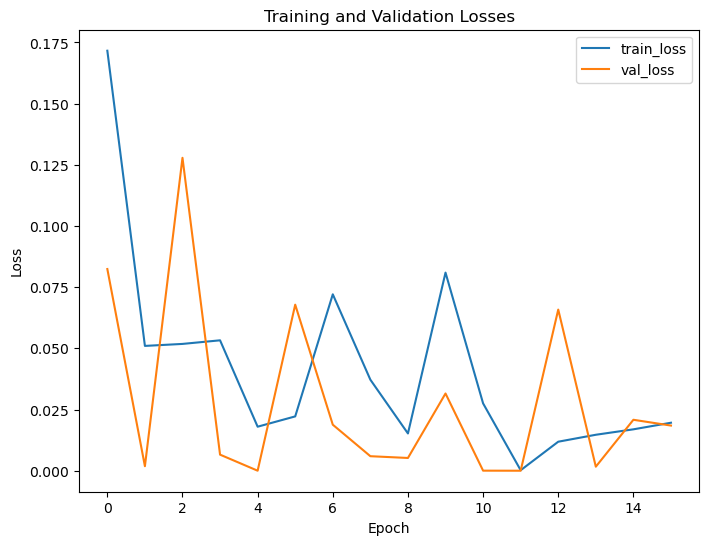

In [56]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'val_loss']:
    plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

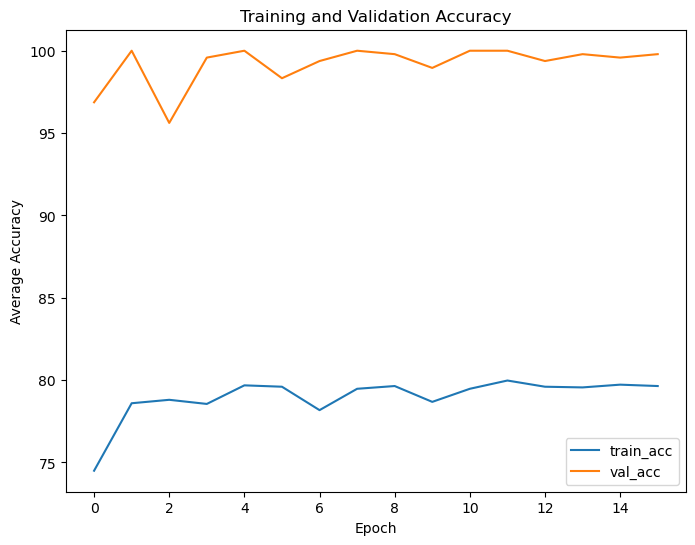

In [57]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'val_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [46]:
if args['model']=='vgg':
    torch.save(model.state_dict(), VGG_Model_path)
elif args['model']=='resnet':
    torch.save(model.state_dict(), RESNET_Model_path)    
elif args['model']=='mobilenet':
    torch.save(model.state_dict(), MobileNet_Model_path )   

# Viewing Results in a Dataframe

In [60]:
import numpy as np
np.round(history,3)

,train_loss,val_loss,train_acc,val_acc
0,0.172,0.082,0.745,0.969
1,0.051,0.002,0.786,1.000
2,0.052,0.128,0.788,0.956
3,0.053,0.007,0.786,0.996
4,0.018,0.000,0.797,1.000
5,0.022,0.068,0.796,0.983
6,0.072,0.019,0.782,0.994
7,0.037,0.006,0.795,1.000
8,0.015,0.005,0.796,0.998
9,0.081,0.032,0.787,0.990


In [47]:
gc.collect()
torch.cuda.empty_cache()

Conclusion:

When using transfer learning, despite subjecting training data to various data augmentation techniques, my model's performance (training accuracy) did not substantially improve. This indicated that data augmentation and transfer learning only works on specific use cases depending on the application. My testing accuracy was far better than my training accuracy, indicating underfitting, However, this may be the case due to the measures taken to reduce overfitting. Some of the measures included regularization (including dropouts), and introducing double non-linearity. Nevertheless, upon deploying the model, the classification model performed very well with only 5 false negatives.

Transfer learning may not always be the best approach towards computer vision projects. In my case, a custom LetNet architecture w/o transfer learning outperformed other networks while training and testing.

My Results with a custom classifier mounted on MobileNet V2 Architecture:

1) Total size/weight of the model obtained: 16.4MB (Target: <40MB)
2) Model F1 Score: 0.99 (Target: >=0.90)
